# Este es el Jupyter Notebook que se ha utilizado para probar modelos de Machine Learning con diferentes variables y diferentes transformaciones

In [ ]:
# pip install catboost
# %pip install hyperopt
# %pip install lightgbm

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR, AdaBoostRegressor as ABR, BaggingRegressor as BR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor as CBR

In [2]:
from sklearn.model_selection import GridSearchCV  
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from lightgbm import LGBMRegressor as LGBMR
from sklearn.svm import SVR
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

In [121]:
bnb = pd.read_csv("../data/train_clean3.csv")

In [122]:
pd.set_option('display.max_columns', None)
bnb.head()

,log_price,room_type,cleaning_fee,cancellation_policy,city,host_experience,accommodates,bathrooms,bedrooms,property_type,mean_log_price,neighbourhood_cluster,neighbourhood
0,4.499810,Entire home/apt,1,flexible,NYC,poco_experimentado,2,1.0,1,Apartment,4.594133,6,Astoria
1,3.970292,Private room,1,strict,NYC,experimentado,2,1.0,1,Apartment,4.594133,5,Hamilton Heights
2,4.787492,Entire home/apt,1,moderate,NYC,muy_experimentado,4,1.0,1,Apartment,5.072061,5,Bedford-Stuyvesant
3,4.700480,Entire home/apt,0,moderate,NYC,muy_experimentado,3,1.1,1,Apartment,4.861277,7,Clinton Hill
4,5.192957,Entire home/apt,1,strict,NYC,muy_experimentado,3,1.0,1,Apartment,4.861277,7,Long Island City


In [99]:
bnb.columns

Index(['log_price', 'room_type', 'cleaning_fee', 'cancellation_policy', 'city',
       'host_experience', 'accommodates', 'bathrooms', 'bedrooms',
       'property_type', 'mean_log_price', 'neighbourhood_cluster',
       'neighbourhood'],
      dtype='object')

# Matriz de correlaciones 

C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\1445928400.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(bnb.corr(), dtype=bool))    # mascara para tapar lo de arriba
C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\1445928400.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(bnb.corr(),


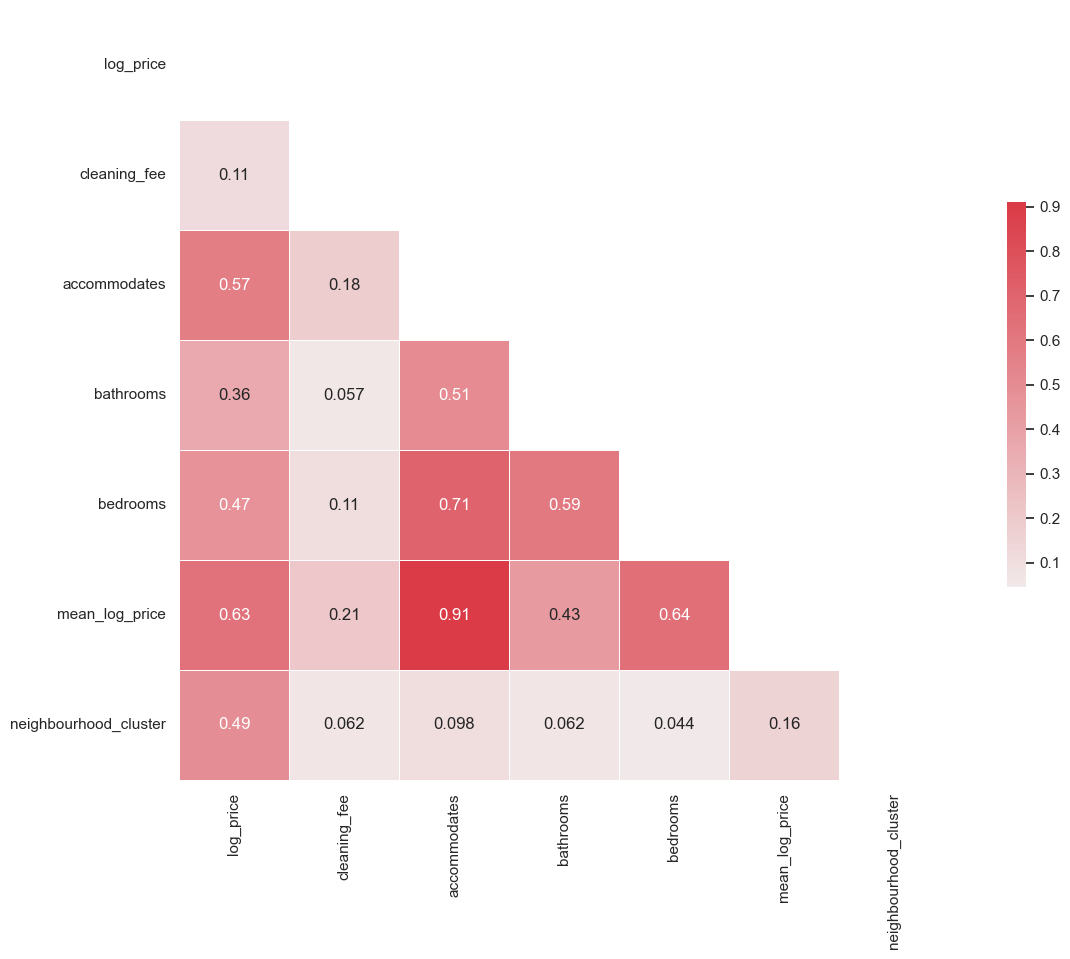

In [123]:
plt.figure(figsize=(15, 10))   # 150x100 pixeles

sns.set(style='white')    # estilo blanco

mask=np.triu(np.ones_like(bnb.corr(), dtype=bool))    # mascara para tapar lo de arriba

cmap=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de  colores


sns.heatmap(bnb.corr(),    
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

# Filtro por variables categóricas de interes y numéricas de mayor correlación

In [124]:
cols =['log_price','room_type','bathrooms', 'bedrooms', 'neighbourhood_cluster','mean_log_price']

bnb2 = bnb[cols]

# Matriz de correlaciones definitiva

C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\3409553626.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(bnb2.corr(), dtype=bool))    # mascara para tapar lo de arriba
C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\3409553626.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(bnb2.corr(),


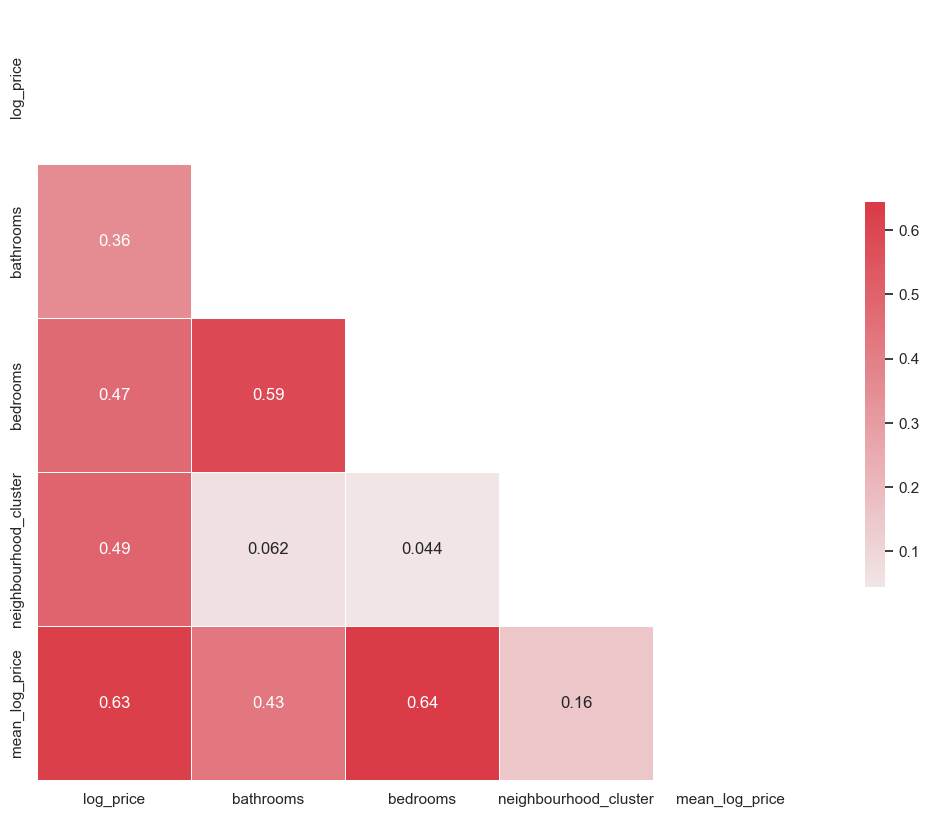

In [125]:
plt.figure(figsize=(15, 10))   # 150x100 pixeles

sns.set(style='white')    # estilo blanco

mask=np.triu(np.ones_like(bnb2.corr(), dtype=bool))    # mascara para tapar lo de arriba

cmap=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de  colores


sns.heatmap(bnb2.corr(),    
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

# One hot encoding

In [126]:

bnb2 = pd.get_dummies(bnb2, columns=['room_type'], drop_first=True)


# Conversión de columnas a categóricas

In [106]:
categorical_columns = ['property_type', 'city', 'room_type','neighbourhood','property_type', 'accommodates']

# Itera sobre las columnas y conviértelas a categorías
for column in categorical_columns:
    bnb2[column] = bnb2[column].astype('category')


KeyError: 'property_type'

# Generación de Train y Test

In [127]:
X = bnb2.drop('log_price', axis=1)

y = bnb2.log_price

In [128]:

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=0.8, 
                                       test_size=0.2
                                      ,random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47430, 6), (11858, 6), (47430,), (11858,))

# Normalización y Label encoder

In [129]:
escalador = StandardScaler()    # inicia el normalizador
 
X_train[['bathrooms','bedrooms']] = escalador.fit_transform(X_train[['bathrooms','bedrooms']])   # transforma train

In [130]:
X_test[['bathrooms','bedrooms']] = escalador.transform(X_test[['bathrooms','bedrooms']])  # transforma test

In [ ]:

# label = LabelEncoder()

# X_train.city = label.fit_transform(X_train.city)

# X_test.city = label.fit_transform(X_test.city)

# X_train.host_experience = label.fit_transform(X_train.host_experience)

# X_test.host_experience = label.fit_transform(X_test.host_experience)

# X_train.cancellation_policy = label.fit_transform(X_train.cancellation_policy)

# X_test.cancellation_policy = label.fit_transform(X_test.cancellation_policy)

In [131]:
X_train.head()

,bathrooms,bedrooms,neighbourhood_cluster,mean_log_price,room_type_Private room,room_type_Shared room
8322,-0.406374,0.862091,8,5.253217,0,0
9750,-0.406374,-0.308741,7,4.226266,1,0
26187,-0.406374,-0.308741,9,5.072061,0,0
2211,-0.406374,-0.308741,7,4.594133,0,0
55503,1.303448,0.862091,9,5.364097,0,0


In [132]:
X_test.head()

,bathrooms,bedrooms,neighbourhood_cluster,mean_log_price,room_type_Private room,room_type_Shared room
21789,-0.406374,0.862091,9,5.072061,0,0
13438,3.013269,-0.308741,5,3.030859,0,1
46523,1.303448,2.032924,5,5.572656,1,0
9902,1.303448,0.862091,7,5.337610,0,0
38899,-0.406374,0.862091,8,4.861277,0,0


# Entrenamiento de diversos modelos de Regresión

In [111]:
cbr = CBR(depth = 10, iterations= 500, learning_rate= 0.05) 
cbr.fit(X_train, y_train)

0:	learn: 0.6985054	total: 7.74ms	remaining: 3.86s
1:	learn: 0.6781106	total: 15.1ms	remaining: 3.76s
2:	learn: 0.6592576	total: 21.9ms	remaining: 3.63s
3:	learn: 0.6416606	total: 28.7ms	remaining: 3.56s
4:	learn: 0.6251340	total: 35.3ms	remaining: 3.49s
5:	learn: 0.6099971	total: 43.2ms	remaining: 3.56s
6:	learn: 0.5956036	total: 50.2ms	remaining: 3.53s
7:	learn: 0.5822083	total: 57.1ms	remaining: 3.51s
8:	learn: 0.5696857	total: 63.6ms	remaining: 3.47s
9:	learn: 0.5580710	total: 70.2ms	remaining: 3.44s
10:	learn: 0.5479462	total: 77ms	remaining: 3.42s
11:	learn: 0.5381777	total: 83.4ms	remaining: 3.39s
12:	learn: 0.5292066	total: 88.9ms	remaining: 3.33s
13:	learn: 0.5205476	total: 95.3ms	remaining: 3.31s
14:	learn: 0.5126384	total: 101ms	remaining: 3.27s
15:	learn: 0.5053759	total: 108ms	remaining: 3.26s
16:	learn: 0.4984295	total: 115ms	remaining: 3.26s
17:	learn: 0.4921776	total: 121ms	remaining: 3.25s
18:	learn: 0.4861650	total: 128ms	remaining: 3.24s
19:	learn: 0.4808816	total: 1

179:	learn: 0.4052777	total: 1.24s	remaining: 2.2s
180:	learn: 0.4052374	total: 1.25s	remaining: 2.2s
181:	learn: 0.4052337	total: 1.25s	remaining: 2.19s
182:	learn: 0.4051994	total: 1.26s	remaining: 2.18s
183:	learn: 0.4051515	total: 1.27s	remaining: 2.18s
184:	learn: 0.4051131	total: 1.27s	remaining: 2.17s
185:	learn: 0.4050651	total: 1.28s	remaining: 2.17s
186:	learn: 0.4049989	total: 1.29s	remaining: 2.16s
187:	learn: 0.4049615	total: 1.3s	remaining: 2.15s
188:	learn: 0.4048455	total: 1.3s	remaining: 2.15s
189:	learn: 0.4048183	total: 1.31s	remaining: 2.14s
190:	learn: 0.4047973	total: 1.32s	remaining: 2.13s
191:	learn: 0.4047737	total: 1.33s	remaining: 2.13s
192:	learn: 0.4047557	total: 1.33s	remaining: 2.12s
193:	learn: 0.4046912	total: 1.34s	remaining: 2.11s
194:	learn: 0.4046406	total: 1.35s	remaining: 2.11s
195:	learn: 0.4045838	total: 1.35s	remaining: 2.1s
196:	learn: 0.4045480	total: 1.36s	remaining: 2.1s
197:	learn: 0.4044918	total: 1.37s	remaining: 2.09s
198:	learn: 0.4044

347:	learn: 0.3990642	total: 2.46s	remaining: 1.08s
348:	learn: 0.3990276	total: 2.47s	remaining: 1.07s
349:	learn: 0.3990004	total: 2.48s	remaining: 1.06s
350:	learn: 0.3989185	total: 2.49s	remaining: 1.06s
351:	learn: 0.3988918	total: 2.5s	remaining: 1.05s
352:	learn: 0.3988703	total: 2.5s	remaining: 1.04s
353:	learn: 0.3988194	total: 2.51s	remaining: 1.03s
354:	learn: 0.3987980	total: 2.52s	remaining: 1.03s
355:	learn: 0.3987673	total: 2.53s	remaining: 1.02s
356:	learn: 0.3987143	total: 2.54s	remaining: 1.01s
357:	learn: 0.3986728	total: 2.54s	remaining: 1.01s
358:	learn: 0.3986493	total: 2.55s	remaining: 1s
359:	learn: 0.3986027	total: 2.56s	remaining: 995ms
360:	learn: 0.3985550	total: 2.56s	remaining: 987ms
361:	learn: 0.3985464	total: 2.57s	remaining: 981ms
362:	learn: 0.3985083	total: 2.58s	remaining: 974ms
363:	learn: 0.3984525	total: 2.59s	remaining: 966ms
364:	learn: 0.3984335	total: 2.59s	remaining: 959ms
365:	learn: 0.3984159	total: 2.6s	remaining: 953ms
366:	learn: 0.3983

In [112]:
lgbmr = LGBMR(colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500,num_leaves=50, subsample=0.8,force_row_wise=True, n_jobs=8)
lgbmr.fit(X_train, y_train) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 47430, number of used features: 29
[LightGBM] [Info] Start training from score 4.783401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, max_depth=10,
              n_estimators=500, n_jobs=8, num_leaves=50, subsample=0.8)

In [113]:
y_pred5 = cbr.predict(X_test)
print(mse(y_test, y_pred5, squared=False))
y_pred6 = lgbmr.predict(X_test)
print(mse(y_test, y_pred6, squared=False))


0.4184960748246232
0.42201867534180537


# Análisis genérico de algunos modelos

In [135]:
models = {
    "linear_regression": LinearRegression(),
    "ridge_regression": Ridge(),
    "lasso_regression": Lasso(),
    "decision_tree_regressor": DecisionTreeRegressor(),
    "random_forest_regressor": RFR(),
    "gradient_boosting_regressor": GBR(),
    "svr_rbf": SVR(kernel = "rbf"),
    "svr_linear": SVR(kernel = "linear"),
    "mlp_regressor": MLPRegressor(),
    "elastic_net": ElasticNet(),
    "ada_boost_regressor": ABR(),
    "bagging_regressor": BR()
}

In [136]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits the given machine learning models to the training data and evaluates their performance on the test data.
    Parameters:
    - models (dict): A dictionary where keys are model names and values are the corresponding machine learning models.
    - X_train (array-like): Feature matrix of the training set.
    - X_test (array-like): Feature matrix of the test set.
    - y_train (array-like): True labels of the training set.
    - y_test (array-like): True labels of the test set.
    Returns:
    dict: A dictionary where keys are model names and values are their corresponding accuracy scores on the test set.
    This function takes a dictionary of machine learning models and fits each model to the training data.
    It then evaluates the performance of each model on the provided test data using the `score` method,
    and returns a dictionary of model names and their corresponding accuracy scores.
    """
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_scores[name] = round(mse(y_test, y_pred, squared=False), 5)
    return model_scores

In [137]:
fit_and_score(models, X_train, X_test, y_train, y_test)

{'linear_regression': 0.43487,
 'ridge_regression': 0.43487,
 'lasso_regression': 0.71868,
 'decision_tree_regressor': 0.45839,
 'random_forest_regressor': 0.44005,
 'gradient_boosting_regressor': 0.42797,
 'svr_rbf': 0.43102,
 'svr_linear': 0.43626,
 'mlp_regressor': 0.43092,
 'elastic_net': 0.68278,
 'ada_boost_regressor': 0.52805,
 'bagging_regressor': 0.44153}

# Busqueda de Hiperparámetros de los modelos de mayor éxito

# GRIDSEARCH PARA rfr

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid
# params = {'n_estimators': [10, 20, 50, 100, 150, 200, 500],
#           'max_depth': [5, 10, 20, 25]}
# modelo = RFR()

# mejor_modelo = grid(modelo, params, X_train, y_train, X_test, y_test)

# Ahora puedes usar mejor_modelo para hacer predicciones u otras operaciones.
# Mejor RMSE en test: 0.44
# Mejor RMSE en train: 0.39
# Mejores parametros: {'max_depth': 10, 'n_estimators': 200}
# Mejor RMSE cv: 0.42

# GRIDSEARCH PARA xgbr

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_xgb(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_xgb
# params_xgb = {'n_estimators': [20, 100, 150, 200, 500],
#               'max_depth': [5, 10, 20, 25],
#               'learning_rate': [0.001, 0.01, 0.1]}
# modelo_xgb = XGBRegressor()

# mejor_modelo_xgb = grid_xgb(modelo_xgb, params_xgb, X_train, y_train, X_test, y_test)
# # Mejor RMSE en test: 0.43
# # Mejor RMSE en train: 0.40
# # Mejores parametros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# # Mejor RMSE cv: 0.41

# GRIDSEARCH PARA mlp

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_mlp(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_mlp
# params_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#               'activation': ['relu', 'tanh'],
#               'alpha': [0.0001, 0.001, 0.01]}
# modelo_mlp = MLPRegressor()

# mejor_modelo_mlp = grid_mlp(modelo_mlp, params_mlp, X_train, y_train, X_test, y_test)


# GRIDSEARCH PARA LGBMRegressor

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_lgbm(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_lgbm
# params_lgbm = {'n_estimators': [50, 100, 200],
#                'learning_rate': [0.01, 0.1, 0.2],
#                'max_depth': [5, 10, 15],
#                'subsample': [0.8, 0.9, 1.0]}
# modelo_lgbm = LGBMR()

# mejor_modelo_lgbm = grid_lgbm(modelo_lgbm, params_lgbm, X_train, y_train, X_test, y_test)
# # Mejor RMSE en train: 0.39
# # Mejores parametros: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}
# # Mejor RMSE cv: 0.41

# GRIDSEARCH PARA GradientBoostingRegressor

In [ ]:
# Definir la métrica de RMSE como scorer
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

def grid_gb(modelo, params, X_train, y_train, X_test, y_test):

    g = GridSearchCV(modelo,     # modelo de ML de sklearn
                     params,     # dictio de params a probar
                     cv=5,       # cv=cross-validation
                     return_train_score=True,   # error de entrenamiento
                     n_jobs=8,                  # usa todos los cores
                     scoring=rmse_scorer        # métrica de RMSE
                    )

    g.fit(X_train, y_train)

    # ajuste de todos los modelos y combinaciones
    print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
    print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
    print('Mejores parametros: {}'.format(g.best_params_))
    print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

    # Retornar el mejor modelo ajustado
    return g.best_estimator_

# Uso de la función grid_gb
params_gb = {'n_estimators': [50, 100, 200],
             'learning_rate': [0.01, 0.1, 0.2],
             'max_depth': [3, 5, 7]}
modelo_gb = GradientBoostingRegressor()

mejor_modelo_gb = grid_gb(modelo_gb, params_gb, X_train, y_train, X_test, y_test)

# Ahora puedes usar mejor_modelo_gb para hacer predicciones u otras operaciones.

# GRIDSEARCH PARA Catboosregressor

In [ ]:
# # Definir el espacio de búsqueda de hiperparámetros para CatBoostRegressor
# param_grid_catboost = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'depth': [4, 6, 8, 10],
# }

# # Crear el modelo CatBoostRegressor
# catboost_model = CBR()

# # Realizar la búsqueda de hiperparámetros
# grid_search_catboost = GridSearchCV(
#     estimator=catboost_model,
#     param_grid=param_grid_catboost,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=8
# )
# grid_result_catboost = grid_search_catboost.fit(X_train, y_train)

# # Obtener los mejores parámetros
# best_params_catboost = grid_result_catboost.best_params_
# print(f"Mejores parámetros para CatBoost: {best_params_catboost}")

# # Obtener el modelo con los mejores parámetros
# best_model_catboost = grid_result_catboost.best_estimator_

# # Evaluación del modelo
# y_pred_catboost = best_model_catboost.predict(X_test)
# rmse_catboost = mse(y_test, y_pred_catboost, squared=False)
# print(f"RMSE en conjunto de prueba: {rmse_catboost}")

# Entrenamiento y testeo de modelos con los hiperparámetros óptimos

In [114]:
rfr = RFR(max_depth= 10, n_estimators= 200)

rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [115]:
xgbr = XGBRegressor(
    objective='reg:squarederror',  # Puedes usar 'reg:squaredlogerror' para regresión logarítmica
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200
)

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [116]:
mlp = MLPRegressor(activation= 'tanh', alpha= 0.001, hidden_layer_sizes= (50, 50))

mlp.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50))

In [119]:
gbr = GBR(learning_rate= 0.05, max_depth= 10, n_estimators= 200)    # inicia el modelo


gbr.fit(X_train, y_train)   # entrena el modelo

GradientBoostingRegressor(learning_rate=0.05, max_depth=10, n_estimators=200)

In [120]:
y_pred1 = rfr.predict(X_test)
print(mse(y_test, y_pred1, squared=False))
y_pred2 = xgbr.predict(X_test)
print(mse(y_test, y_pred2, squared=False))
y_pred3 = mlp.predict(X_test)
print(mse(y_test, y_pred3, squared=False))
y_pred4 = gbr.predict(X_test)
print(mse(y_test, y_pred4, squared=False))

y_pred5 = cbr.predict(X_test)
print(mse(y_test, y_pred5, squared=False))
y_pred6 = lgbmr.predict(X_test)
print(mse(y_test, y_pred6, squared=False))


0.425501232387424
0.41918012535830773
0.422896517669788
0.42844217956308484
0.4184960748246232
0.42201867534180537


# Combinación de resultados de diferentes modelos

In [ ]:
modelos = [rfr, xgbr, mlp, gbr,cbr,lgbmr]
predicciones = [modelo.predict(X_test) for modelo in modelos]


def error_total(pesos):
    combinacion_lineal = np.dot(np.array(predicciones).T, pesos)
    return mse(y_test, combinacion_lineal, squared=False)

# Definir límites para los pesos (pueden variar según tus necesidades)
bounds = [(0, 1)] * len(modelos)

# Realizar la optimización heurística
resultado_optimizacion = differential_evolution(error_total, bounds, seed=42)

# Obtener los pesos óptimos
pesos_optimos = resultado_optimizacion.x

# Evaluar el rendimiento con los pesos óptimos
combinacion_lineal_optima = np.dot(np.array(predicciones).T, pesos_optimos)
mse_optimo = mse(y_test, combinacion_lineal_optima, squared=False)

print("Pesos óptimos:", pesos_optimos)
print("MSE óptimo:", mse_optimo)